# FraudWatch — Camada de Decisioning e Política de Risco

## Objetivo deste notebook

Este notebook implementa a **camada de decisioning** da POC FraudWatch.

O foco desta etapa não é o treinamento de modelos, mas a conversão do score de risco
gerado pelo modelo campeão em **decisões operacionais explícitas, rastreáveis e auditáveis**.

Neste contexto, o modelo atua exclusivamente como **insumo para a decisão**,
enquanto as regras de ação são definidas de forma determinística e documentada.

---

## Papel do decisioning na FraudWatch

No contexto da FraudWatch, a camada de decisioning:

- estabelece a separação explícita entre **predição** e **decisão**;
- formaliza políticas de risco baseadas em score;
- explicita os trade-offs entre risco e custo operacional;
- permite a simulação e o ajuste de políticas sem necessidade de retreinamento do modelo;
- prepara a solução para integração com sistemas downstream.

Este notebook marca a transição da FraudWatch
de um modelo preditivo para um **motor de decisão estruturado e governável**.

---

## Escopo e decisões importantes

- O modelo utilizado foi treinado, validado e selecionado no Notebook 03.
- Os thresholds aplicados são definidos a partir do conjunto de validação.
- O conjunto de teste não é utilizado para calibrar decisões, sendo empregado apenas para validação de estabilidade.
- Nenhuma decisão é aprendida automaticamente:
  todas as regras adotadas são **explícitas, determinísticas e documentadas**.

## 1. Setup e parâmetros globais

In [1]:
# Importação de bibliotecas

# 1. Standard library
import json
import sys
import warnings

sys.path.insert(0, "..")


# 2. Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

# 3. Local (projeto)
from src.paths import (
    MODELS_FOLDER,
    REPORTS_FOLDER,
    PROCESSED_TEST,
    CHAMPION_METRICS_TEST,
    CHAMPION_METRICS_VALID,
    DECISION_POLICY,
)

# Silenciar warning conhecido do NumPy disparado internamente pelo SHAP
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The NumPy global RNG was seeded"
)

SEED = 42
np.random.seed(SEED)

# 4. Configurações de display / plots
pd.set_option("display.float_format", "{:.4f}".format)

sns.set_theme(style="whitegrid", context="notebook")

## 2. Carregar artefatos

In [2]:
# Carregar modelo
champion_model= MODELS_FOLDER / "champion_lightgbm.pkl"
model = joblib.load(champion_model)

# Carrgar métricas e thersholds modelo campeão
with open(CHAMPION_METRICS_VALID, "r", encoding="utf-8") as f:
    metrics_valid = json.load(f)

# Carregar TEST
test_df = pd.read_parquet(PROCESSED_TEST)

## 3. Política de decisão baseada em score

O score de risco gerado pelo modelo é utilizado como insumo para uma política de decisão **multinível**, não resultando em uma classificação binária direta.

A política de risco adotada é estruturada em três faixas operacionais:

- **Baixo risco** → aprovação automática;
- **Risco intermediário** → encaminhamento para revisão manual;
- **Alto risco** → bloqueio automático.

Essa política é definida com o objetivo de equilibrar cobertura de fraudes, custo operacional e impacto na experiência do cliente.

In [3]:
def decision_policy(score, t1, t2):
    """
    Política de decisão baseada em score de risco.

    Parâmetros
    ----------
    score : float
        Score de risco (probabilidade de fraude).
    t1 : float
        Threshold inferior (approve → review).
    t2 : float
        Threshold superior (review → block).

    Retorna
    -------
    decision : str
        Uma das decisões: 'approve', 'review', 'block'
    """
    if score < t1:
        return "approve"
    elif score < t2:
        return "review"
    else:
        return "block"

### 3.1 Definição dos thresholds operacionais (approve / review / block)

A política de decisão utiliza o score contínuo produzido pelo modelo campeão para mapear risco em ações operacionais, por meio de dois thresholds configuráveis, que definem três faixas de decisão:

- **t1**: limiar entre *approve* e *review*, delimitando a zona de revisão manual;
- **t2**: limiar entre *review* e *block*, acionando bloqueio automático para eventos de alto risco.

As regras de decisão são definidas de forma determinística:

- score < t1 → *approve*
- t1 ≤ score < t2 → *review*
- score ≥ t2 → *block*

#### Estratégia de definição dos thresholds (V1)

O threshold **t2** é herdado diretamente do conjunto de validação (Notebook 03), sendo definido como o valor que satisfaz a política mínima de precisão estabelecida, mantendo simultaneamente alto recall para eventos de fraude. Esse threshold representa o ponto de bloqueio automático do sistema.

O threshold **t1** é definido como uma fração de t2, de acordo com a relação:

`t1 = 0.7 · t2`

Essa definição cria uma faixa intermediária de risco destinada à revisão manual, sem alterar a política de bloqueio automático definida por t2.

In [4]:
# t2 (review→block) herdado do VALID — definido no Notebook 03
t2 = float(metrics_valid["chosen_threshold"])

# t1 (approve→review) definido como fração de t2 (faixa intermediária de review)
t1 = 0.7 * t2

print(f"t1 (approve→review): {t1:.6f}")
print(f"t2 (review→block)  : {t2:.6f}")

assert 0 < t1 < t2 < 1, "Thresholds inválidos. Verifique valores."

t1 (approve→review): 0.009930
t2 (review→block)  : 0.014186


#### Justificativa da definição de t1

O fator multiplicativo aplicado a t2 (0.7) não é arbitrário. Esse valor foi avaliado em um intervalo de teste (0.5–0.9) no conjunto de validação, considerando simultaneamente:

- volume de transações encaminhadas para *review*;
- taxa de fraude capturada nessa faixa intermediária;
- custo esperado sob a matriz de custo definida.

O valor adotado apresentou o melhor equilíbrio entre capacidade operacional de revisão e cobertura de fraudes na faixa intermediária, minimizando o custo esperado no conjunto de validação, sem impactar a política de bloqueio automático (t2).

Essa abordagem permite ajustar a carga operacional de revisão manual de forma controlada, mantendo a integridade da política de bloqueio.

## 4. Matriz de custo (trade-off explícito)

A política de decisão é fundamentada em uma matriz de custo hipotética, utilizada para explicitar os trade-offs centrais do processo decisório, incluindo:

- **perda financeira** associada à aprovação de fraudes (falsos negativos);
- **impacto em experiência e atrito** associado ao bloqueio de transações legítimas (falsos positivos);
- **custo operacional** relacionado à revisão manual de transações.

Os valores utilizados representam **custos unitários relativos**, não monetários. O objetivo da matriz não é simular impacto financeiro real, mas documentar de forma explícita as prioridades e preferências do processo de decisão adotado.

In [5]:
# Custos unitários relativos (hipotéticos; não monetários)
COST_FP_BLOCK   = 1.0    # bloquear legítimo (atrito/experiência)
COST_FN_APPROVE = 10.0   # aprovar fraude (perda financeira)
COST_REVIEW     = 0.2    # custo operacional por revisão manual

# POC: risco residual após revisão (0.0 = revisão assume decisão correta)
REVIEW_RESIDUAL_RISK = 0.0

def expected_cost(y_true: int, decision: str) -> float:
    """Calcula o custo unitário esperado dado o rótulo real (0/1) e a decisão (*approve/review/block*)."""
    if decision == "approve":
        return COST_FN_APPROVE if y_true == 1 else 0.0

    if decision == "block":
        return COST_FP_BLOCK if y_true == 0 else 0.0

    if decision == "review":
        # custo de revisão + risco residual (se configurado)
        residual = REVIEW_RESIDUAL_RISK * (COST_FN_APPROVE if y_true == 1 else COST_FP_BLOCK)
        return COST_REVIEW + residual

    raise ValueError("decision inválida: use 'approve', 'review' ou 'block'")

### 4.1 Simplificação do custo de revisão manual (escopo da POC)

Nesta versão da POC, a revisão manual é modelada com custo fixo por evento. Adicionalmente, assume-se, por simplicidade, que o processo de revisão apresenta erro residual baixo (≈ 0), ou seja, após a análise humana, a decisão final tende a ser correta.

Em cenários reais, essa taxa residual poderia ser modelada explicitamente, assim como custos variáveis por tipo de transação, valor financeiro ou perfil de risco. Essas extensões são deliberadamente excluídas nesta POC para manter foco na definição e validação da política de decisão.

## 5. Simulação no TEST (holdout)

O conjunto de teste é empregado exclusivamente para a simulação do fluxo completo de decisão, com thresholds previamente fixados.

A simulação tem como finalidades:

- mensurar o impacto operacional da política de decisão, incluindo o volume de eventos classificados como *approve*, *review* e *block*;
- avaliar a cobertura de fraudes em cada faixa de decisão;
- estimar o custo esperado sob a matriz de custo definida.

In [6]:
TARGET_COL = "Class"
DROP_COLS = [TARGET_COL, "Time"] if "Time" in test_df.columns else [TARGET_COL]

In [7]:
X_test = test_df.drop(columns=DROP_COLS)
y_test = test_df[TARGET_COL].astype(int).values

# Score do modelo campeão
proba_test = model.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


In [8]:
# Aplicar policy
decisions = [decision_policy(s, t1=t1, t2=t2) for s in proba_test]

decisions_series = pd.Series(decisions, name="decision")
decisions_series.value_counts(dropna=False)

decision
approve    42381
block        153
review        25
Name: count, dtype: int64

In [9]:
df_sim = pd.DataFrame({
    "score": proba_test,
    "y_true": y_test,
    "decision": decisions_series,
})

# Volume por faixa
volume_by_decision = df_sim["decision"].value_counts().to_frame("count")
volume_by_decision["rate"] = volume_by_decision["count"] / len(df_sim)

# Fraudes capturadas por faixa
fraud_by_decision = df_sim.groupby("decision")["y_true"].sum().to_frame("frauds")
fraud_by_decision["fraud_rate_in_bucket"] = df_sim.groupby("decision")["y_true"].mean()

summary = volume_by_decision.join(fraud_by_decision)

summary

,count,rate,frauds,fraud_rate_in_bucket
decision,,,,
approve,42381,0.9958,10,0.0002
block,153,0.0036,40,0.2614
review,25,0.0006,2,0.0800


In [10]:
df_sim["unit_cost"] = [
    expected_cost(y, d) for y, d in zip(df_sim["y_true"], df_sim["decision"])
]

total_cost = float(df_sim["unit_cost"].sum())
avg_cost = float(df_sim["unit_cost"].mean())

n = len(df_sim)
print(f"Custo total estimado (TEST)     : {total_cost:.2f}")
print(f"Custo médio por transação (TEST): {avg_cost:.6f}")

Custo total estimado (TEST)     : 218.00
Custo médio por transação (TEST): 0.005122


### Resumo da simulação no TEST (holdout)

O conjunto de teste é empregado exclusivamente para a simulação do fluxo completo de decisão
(*approve / review / block*), com thresholds fixos
(t2 herdado do conjunto de validação e t1 definido pela regra adotada).

**Resultados operacionais (volume por decisão)**

- **Approve:** 42.381 transações (99,58%)
- **Review:** 25 transações (0,06%)
- **Block:** 153 transações (0,36%)

A política preserva o fluxo operacional padrão, direcionando apenas uma fração mínima da base para intervenção manual ou bloqueio automático.

**Cobertura de fraude por faixa (qualidade dos buckets)**

- **Block:** 40 fraudes, com **taxa de fraude de 26,14%**;
- **Review:** 2 fraudes, com **taxa de fraude de 8,00%**;
- **Approve:** **taxa de fraude residual de 0,02%**, compatível com uma faixa de baixo risco.

Esses resultados indicam boa separação de risco induzida pelo score do modelo e pela política de thresholds adotada.

**Trade-off via matriz de custo (referência operacional)**

Considerando a matriz de custo definida (FN significativamente mais caro que FP e custo fixo de *review*), a política resulta em:

- **Custo total estimado (TEST): 218.00** para 42.559 transações;
- **Custo médio por transação (TEST): 0.005122**.

Os custos apresentados são **relativos (não monetários)** e têm como finalidade permitir comparação entre políticas alternativas.
O resultado evidencia boa cobertura de fraude com impacto operacional e custo médio controlados.

Com isso, o conjunto de teste valida a **estabilidade e a coerência operacional** da política definida,
permitindo avançar para a etapa de **explicabilidade (SHAP)**.

## 6. Explicabilidade (SHAP)

A camada de explicabilidade utiliza **SHAP** para interpretar o score de risco produzido pelo **modelo campeão (LightGBM)**.

A explicabilidade tem como finalidade exclusiva aumentar a transparência do processo de decisioning, sem reavaliar performance ou introduzir ajustes no modelo, permitindo:

- identificar as variáveis que mais influenciam o score de risco em nível **global**;
- analisar decisões individuais associadas às faixas **approve / review / block**;
- fornecer subsídios objetivos para **análise humana**, especialmente no contexto de revisão manual (*review*).

O SHAP atua estritamente como **camada explicativa**, sem alterar o modelo, interferir na política de decisão ou redefinir thresholds.

In [11]:
# Background 
background = X_test.sample(n=min(20000, len(X_test)), random_state=SEED)

# Amostra para explicação global
X_explain = X_test.sample(n=min(5000, len(X_test)), random_state=SEED)

explainer = shap.TreeExplainer(
    model,
    data=background,
    feature_perturbation="interventional"
)

shap_values = explainer.shap_values(X_explain, check_additivity=False)

shap_values_pos = shap_values[1] if isinstance(shap_values, list) else shap_values

base_value = explainer.expected_value
if isinstance(base_value, (list, np.ndarray)):
    base_value = base_value[1] if len(base_value) > 1 else base_value[0]

100%|===================| 4979/5000 [01:46<00:00]        

### 6.1. SHAP Global

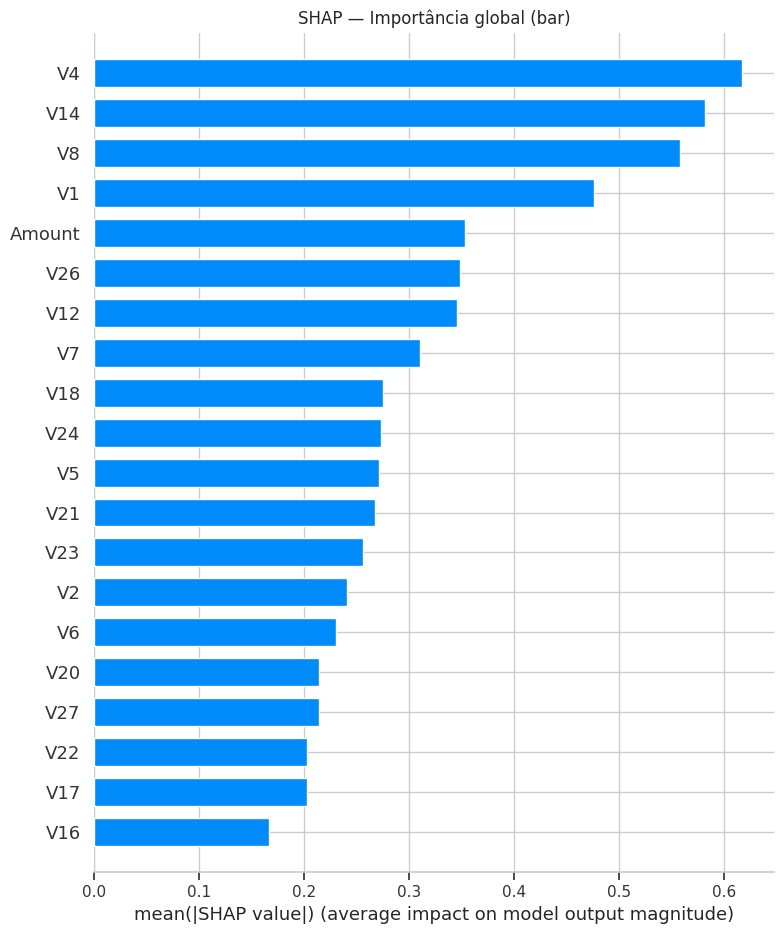

In [12]:
# Importância global das variáveis (SHAP — média absoluta)
shap.summary_plot(shap_values_pos, X_explain, plot_type="bar",cmap="viridis", show=False)
plt.title("SHAP — Importância global (bar)")
plt.tight_layout()
plt.show()

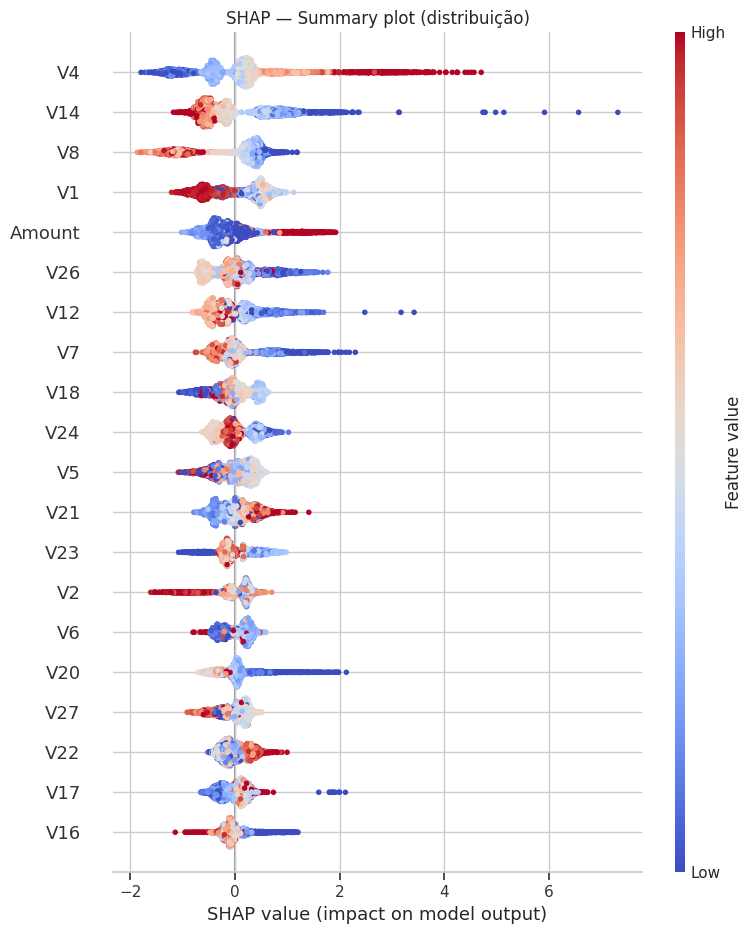

In [13]:
# Distribuição das contribuições por variável (SHAP summary)
shap.summary_plot(shap_values_pos, X_explain, cmap="coolwarm", show=False)
plt.title("SHAP — Summary plot (distribuição)")
plt.tight_layout()
plt.show()

### 6.2. SHAP Local

In [14]:
# Junta tudo num df para facilitar seleção de casos
df_decisions = X_test.copy()
df_decisions["y_true"] = y_test
df_decisions["score"] = proba_test
df_decisions["decision"] = decisions_series.values if hasattr(decisions_series, "values") else decisions_series

df_decisions["idx"] = np.arange(len(df_decisions))

# Função simples: pega um caso "representativo" por bucket
def pick_example(df, decision, kind="top"):
    sub = df[df["decision"] == decision].copy()
    if sub.empty:
        return None
    if kind == "top":
        return int(sub.sort_values("score", ascending=False).iloc[0]["idx"])
    if kind == "mid":
        return int(sub.sort_values("score").iloc[len(sub)//2]["idx"])
    return int(sub.sort_values("score", ascending=True).iloc[0]["idx"])

idx_block  = pick_example(df_decisions, "block",  kind="top")
idx_review = pick_example(df_decisions, "review", kind="top")
idx_approve= pick_example(df_decisions, "approve",kind="top")

idx_block, idx_review, idx_approve

(1628, 42473, 40560)

In [15]:
def plot_local(idx, title):
    """
    Plota explicabilidade local (SHAP waterfall) para UM caso específico do TEST.

    Por que assim:
    - O SHAP global pode ser calculado em uma amostra (rápido).
    - Para exemplos locais (approve/review/block), calculamos SHAP "on demand" só na linha escolhida,
      evitando desalinhamento entre índices do X_test e a matriz SHAP de uma amostra reduzida.
    """
    # Seleciona uma única linha preservando o formato de DataFrame (1 x N features)
    x_row = X_test.iloc[[idx]]

    # Calcula SHAP apenas para esse caso (não depende do X_explain)
    sv = explainer.shap_values(x_row, check_additivity=False)

    # Normaliza saída para classe positiva (fraude=1) quando o explainer retorna lista
    sv_pos = sv[1] if isinstance(sv, list) else sv 

    # Empacota em objeto Explanation para plotar waterfall
    exp = shap.Explanation(
        values=sv_pos[0],
        base_values=base_value,
        data=x_row.iloc[0],
        feature_names=X_test.columns
    )

    #  Waterfall: contribuição de cada feature para empurrar o score pra cima/baixo
    shap.plots.waterfall(exp, max_display=15, show=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

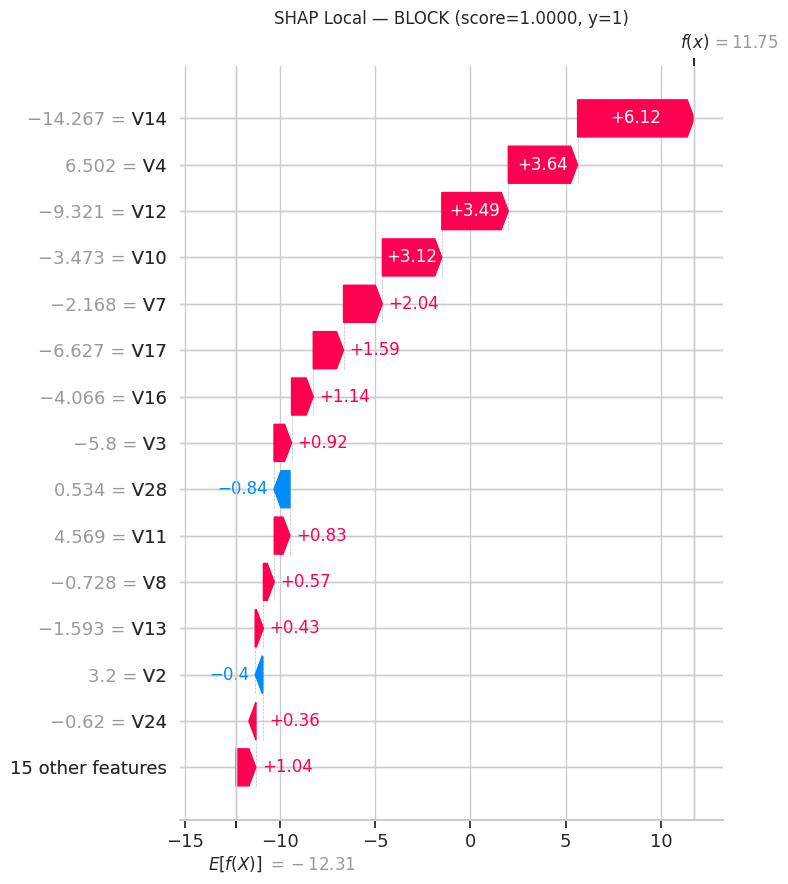

In [16]:
# BLOCK: caso de maior score no bucket "block" (alto risco)
plot_local(idx_block,  f"SHAP Local — BLOCK (score={proba_test[idx_block]:.4f}, y={y_test[idx_block]})")

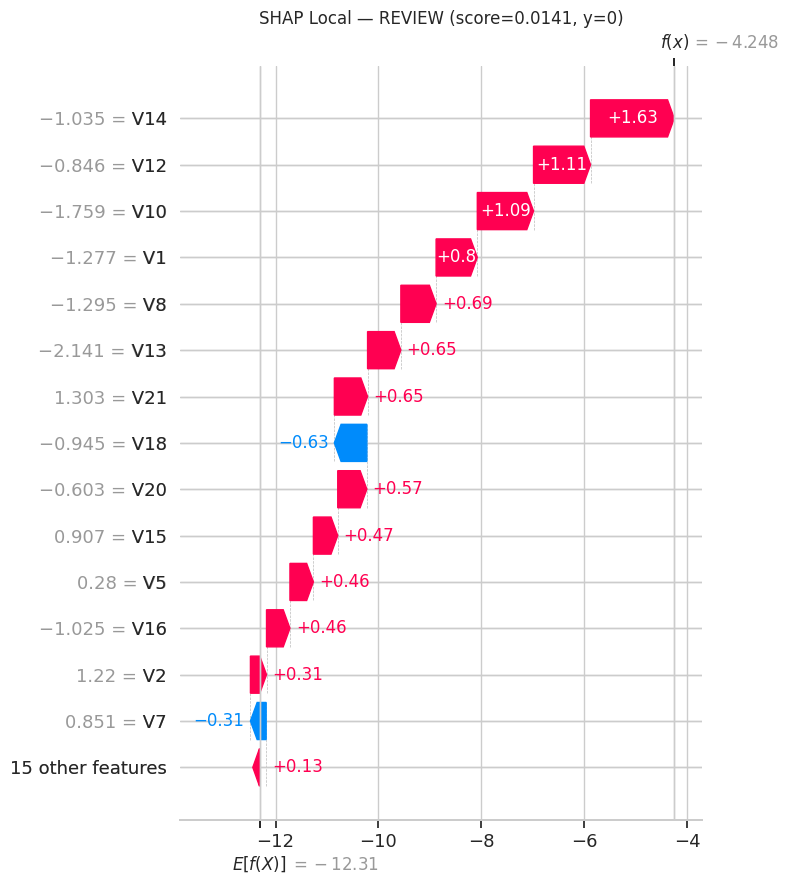

In [17]:
# REVIEW: caso de maior score no bucket "review" (zona cinzenta)
plot_local(idx_review, f"SHAP Local — REVIEW (score={proba_test[idx_review]:.4f}, y={y_test[idx_review]})")

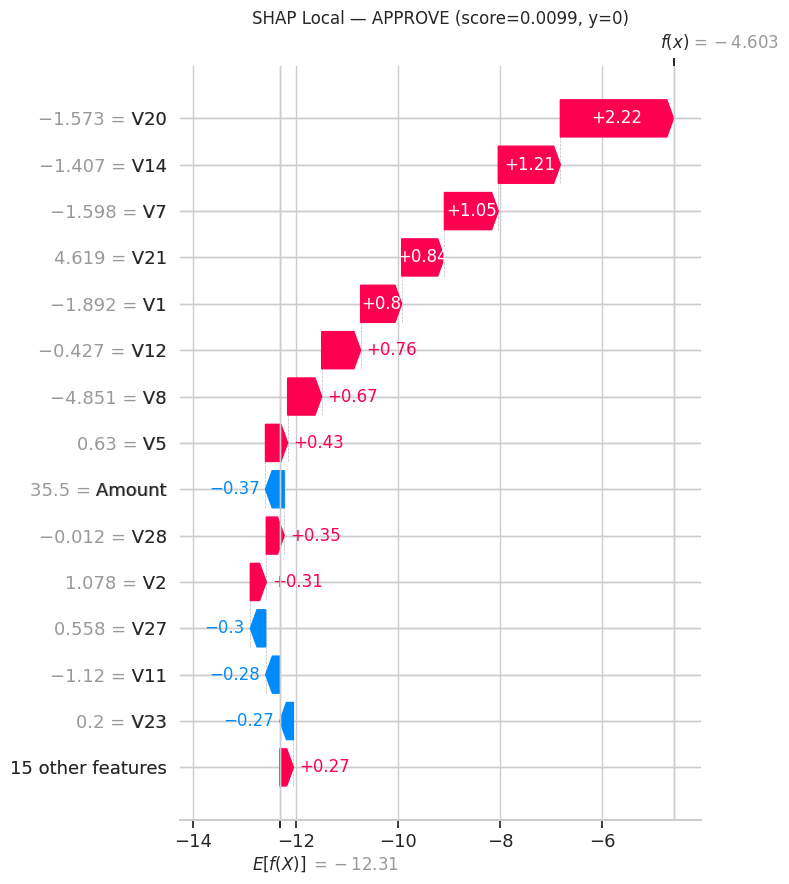

In [18]:
# APPROVE: caso de maior score no bucket "approve" (baixo risco)
plot_local(idx_approve,f"SHAP Local — APPROVE (score={proba_test[idx_approve]:.4f}, y={y_test[idx_approve]})")

### Conclusão da explicabilidade (SHAP)

A análise de explicabilidade indica que o modelo campeão fundamenta suas decisões em um conjunto consistente de variáveis, com contribuições estáveis tanto no nível global quanto em exemplos individuais.

A inspeção de casos classificados como **approve**, **review** e **block** evidencia que:

- decisões automáticas de bloqueio são sustentadas por múltiplos sinais convergentes;
- a faixa de *review* concentra situações de incerteza legítima do modelo;
- casos aprovados apresentam, em geral, contribuições dominantes que reduzem o score de risco.

Dessa forma, a explicabilidade cumpre seu papel como camada de governança, tornando o motor de decisão **auditável, interpretável e defensável**, sem acoplamento a regras manuais ou ajustes subjetivos.

## 6. Persistência da policy

A política de decisão é persistida como um artefato independente do modelo preditivo, constituindo o contrato operacional da camada de decisioning.

Essa separação viabiliza:

- ajustes de thresholds e regras operacionais sem necessidade de retreinamento do modelo;
- versionamento explícito da lógica de decisão;
- auditoria e rastreabilidade das decisões produzidas pelo sistema.

A policy formaliza a interface entre predição e ação:  
o modelo é responsável pela geração do score, enquanto a política define **como o score é convertido em ação** (*approve*, *review* ou *block*).

Esse desacoplamento é um princípio fundamental em sistemas antifraude orientados a negócio, nos quais mudanças operacionais devem ser rápidas, controladas e plenamente explicáveis.

In [19]:
policy_artifact = {
    "policy_name": "fraudwatch_v1_decisioning",
    "t1": float(t1),
    "t2": float(t2),
    "costs": {
        "COST_FP_BLOCK": float(COST_FP_BLOCK),
        "COST_FN_APPROVE": float(COST_FN_APPROVE),
        "COST_REVIEW": float(COST_REVIEW),
    },
    "rules": {
        "approve": "score < t1",
        "review": "t1 <= score < t2",
        "block": "score >= t2",
    },
}

with open(DECISION_POLICY, "w", encoding="utf-8") as f:
    json.dump(policy_artifact, f, indent=2, ensure_ascii=False)

## Encerramento

Este notebook consolida a camada de decisioning da FraudWatch, contemplando:

- definição explícita de uma política de decisão baseada em score;
- formalização de thresholds operacionais;
- documentação dos trade-offs por meio de uma matriz de custo;
- utilização de explicabilidade (SHAP) como suporte à análise humana;
- simulação do fluxo completo de decisão antifraude no conjunto de teste.

Com isso, a FraudWatch deixa de operar apenas como um modelo preditivo e passa a funcionar como um **motor de decisão estruturado, auditável e orientado a políticas explícitas**.